In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Učitavanje obrađenih podataka
Prikaz numerickih deskriptivnih pokazatelja

In [34]:
dataset = pd.read_csv('../data/data_processed.csv')

desc = dataset.describe().round(2)

variance_row = (desc.loc['std'] ** 2).round(2)
variance_row.name = 'variance'
desc = pd.concat([desc, variance_row.to_frame().T])

iqr_row = (desc.loc['75%'] - desc.loc['25%']).round(2)
iqr_row.name = 'IQR'
desc = pd.concat([desc, iqr_row.to_frame().T])

desc = desc.reindex(['count', 'mean', 'std', 'variance', 'min', '25%', '50%', '75%', 'max', 'IQR'])

desc

,Humidity Level,Temperature,Luring Success,Time Spent Hunting,Prey Size,Ambush,Predator Presence,Is Competition,Hunting Success
count,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00
mean,0.60,27.50,0.50,2.73,5.66,0.50,0.50,0.50,0.55
std,0.17,4.33,0.50,1.41,2.82,0.50,0.50,0.50,0.50
variance,0.03,18.75,0.25,1.99,7.95,0.25,0.25,0.25,0.25
min,0.30,20.00,0.00,0.40,1.00,0.00,0.00,0.00,0.00
25%,0.45,23.74,0.00,1.55,3.31,0.00,0.00,0.00,0.00
50%,0.60,27.50,1.00,2.69,5.59,0.00,0.00,0.00,1.00
75%,0.75,31.25,1.00,3.84,7.88,1.00,1.00,1.00,1.00
max,0.90,35.00,1.00,10.19,20.97,1.00,1.00,1.00,1.00
IQR,0.30,7.51,1.00,2.29,4.57,1.00,1.00,1.00,1.00


Histogram

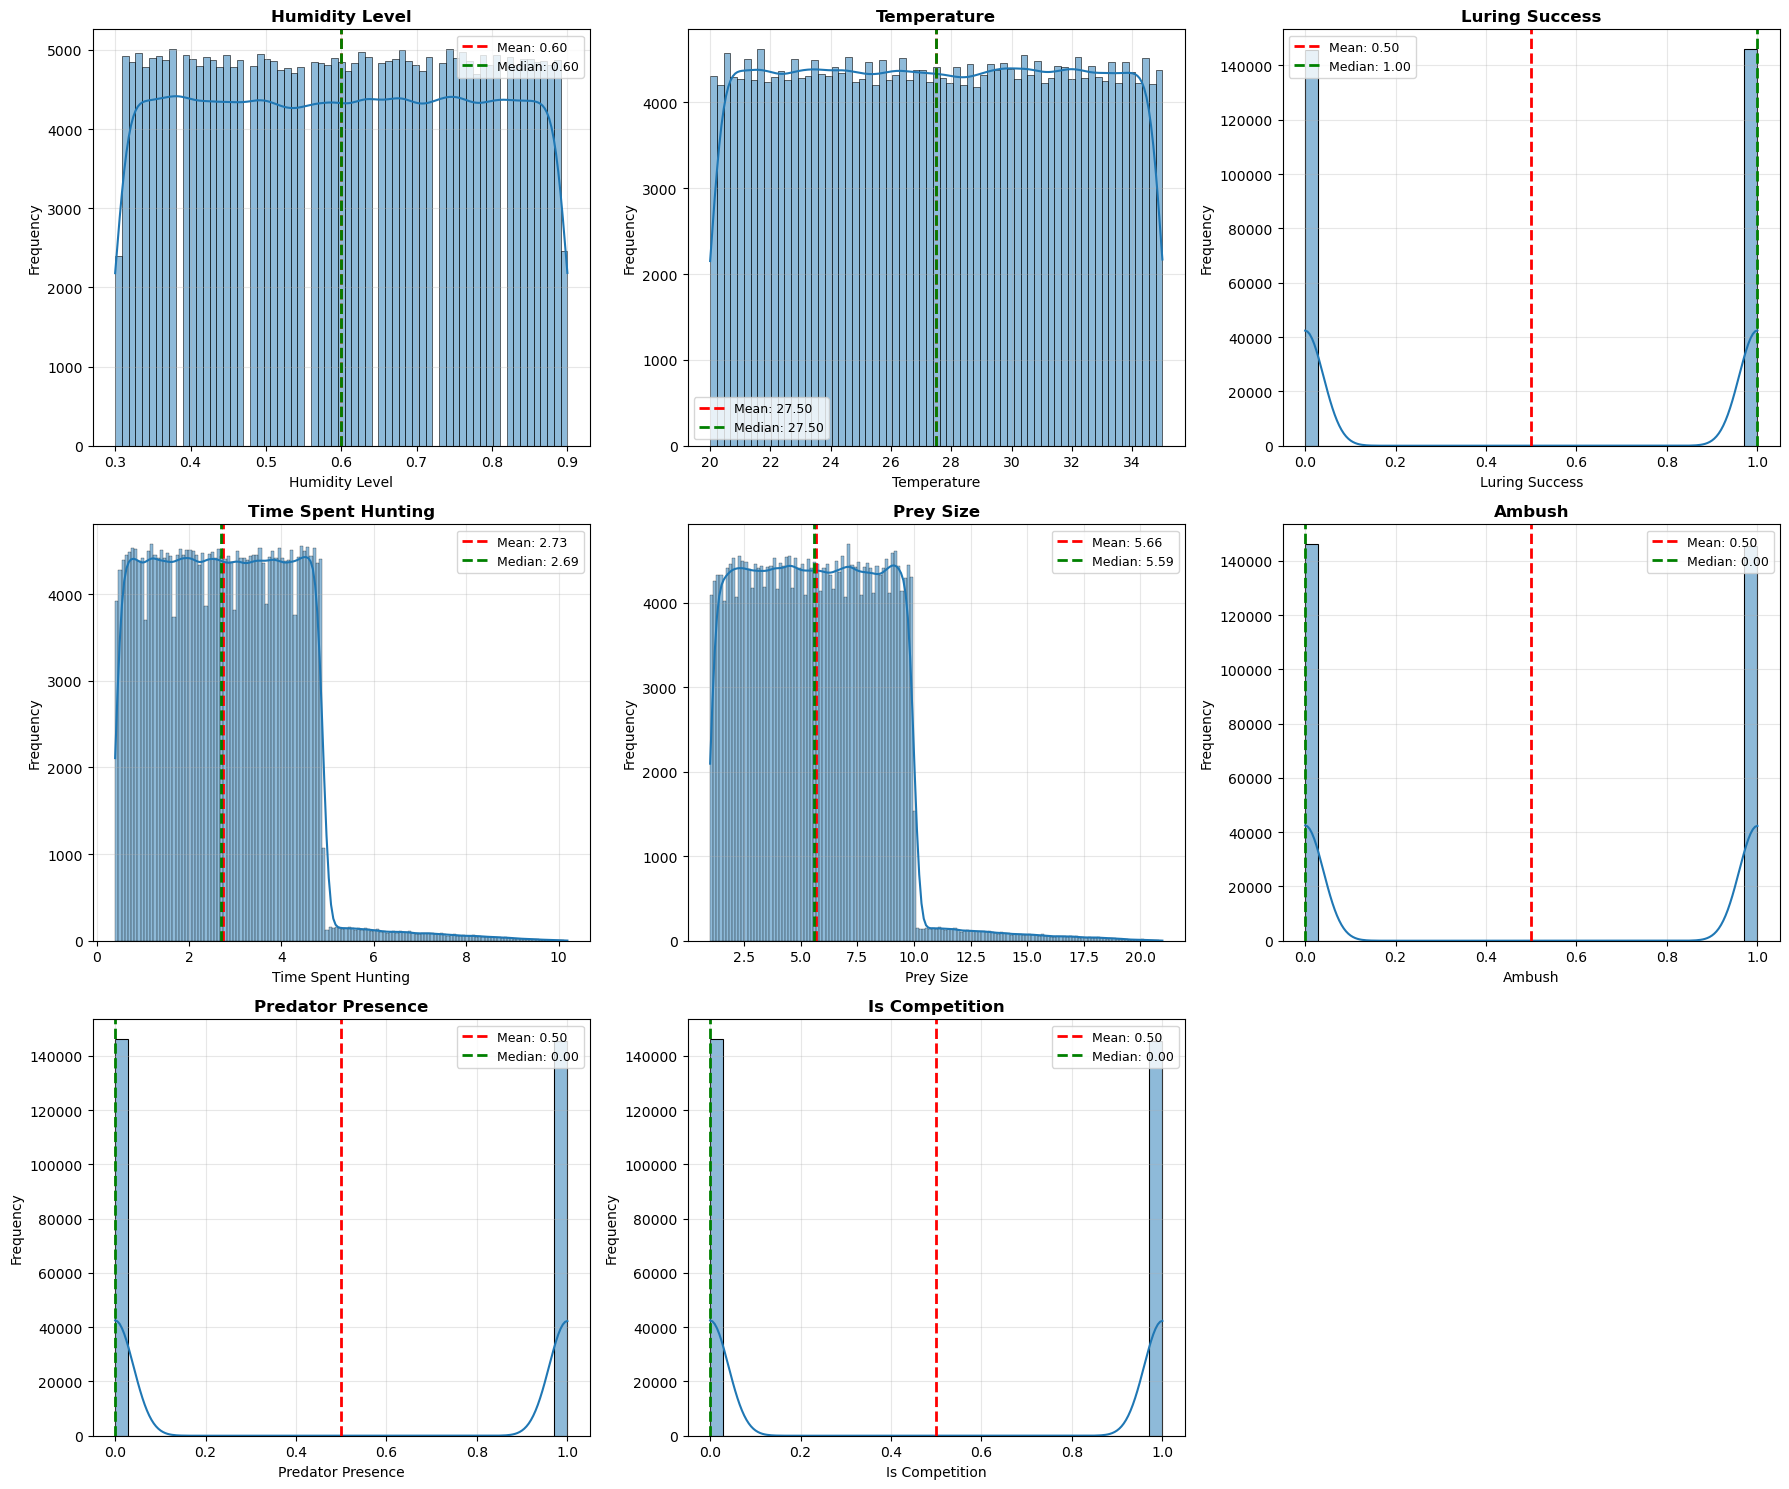

In [ ]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if len(num_cols) > 1 else [axes] if n_rows == 1 else axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(dataset[col], kde=True, ax=axes[i])
    
    mean_val = dataset[col].mean()
    median_val = dataset[col].median()
    
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(alpha=0.3)

for i in range(len(num_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Boxplots


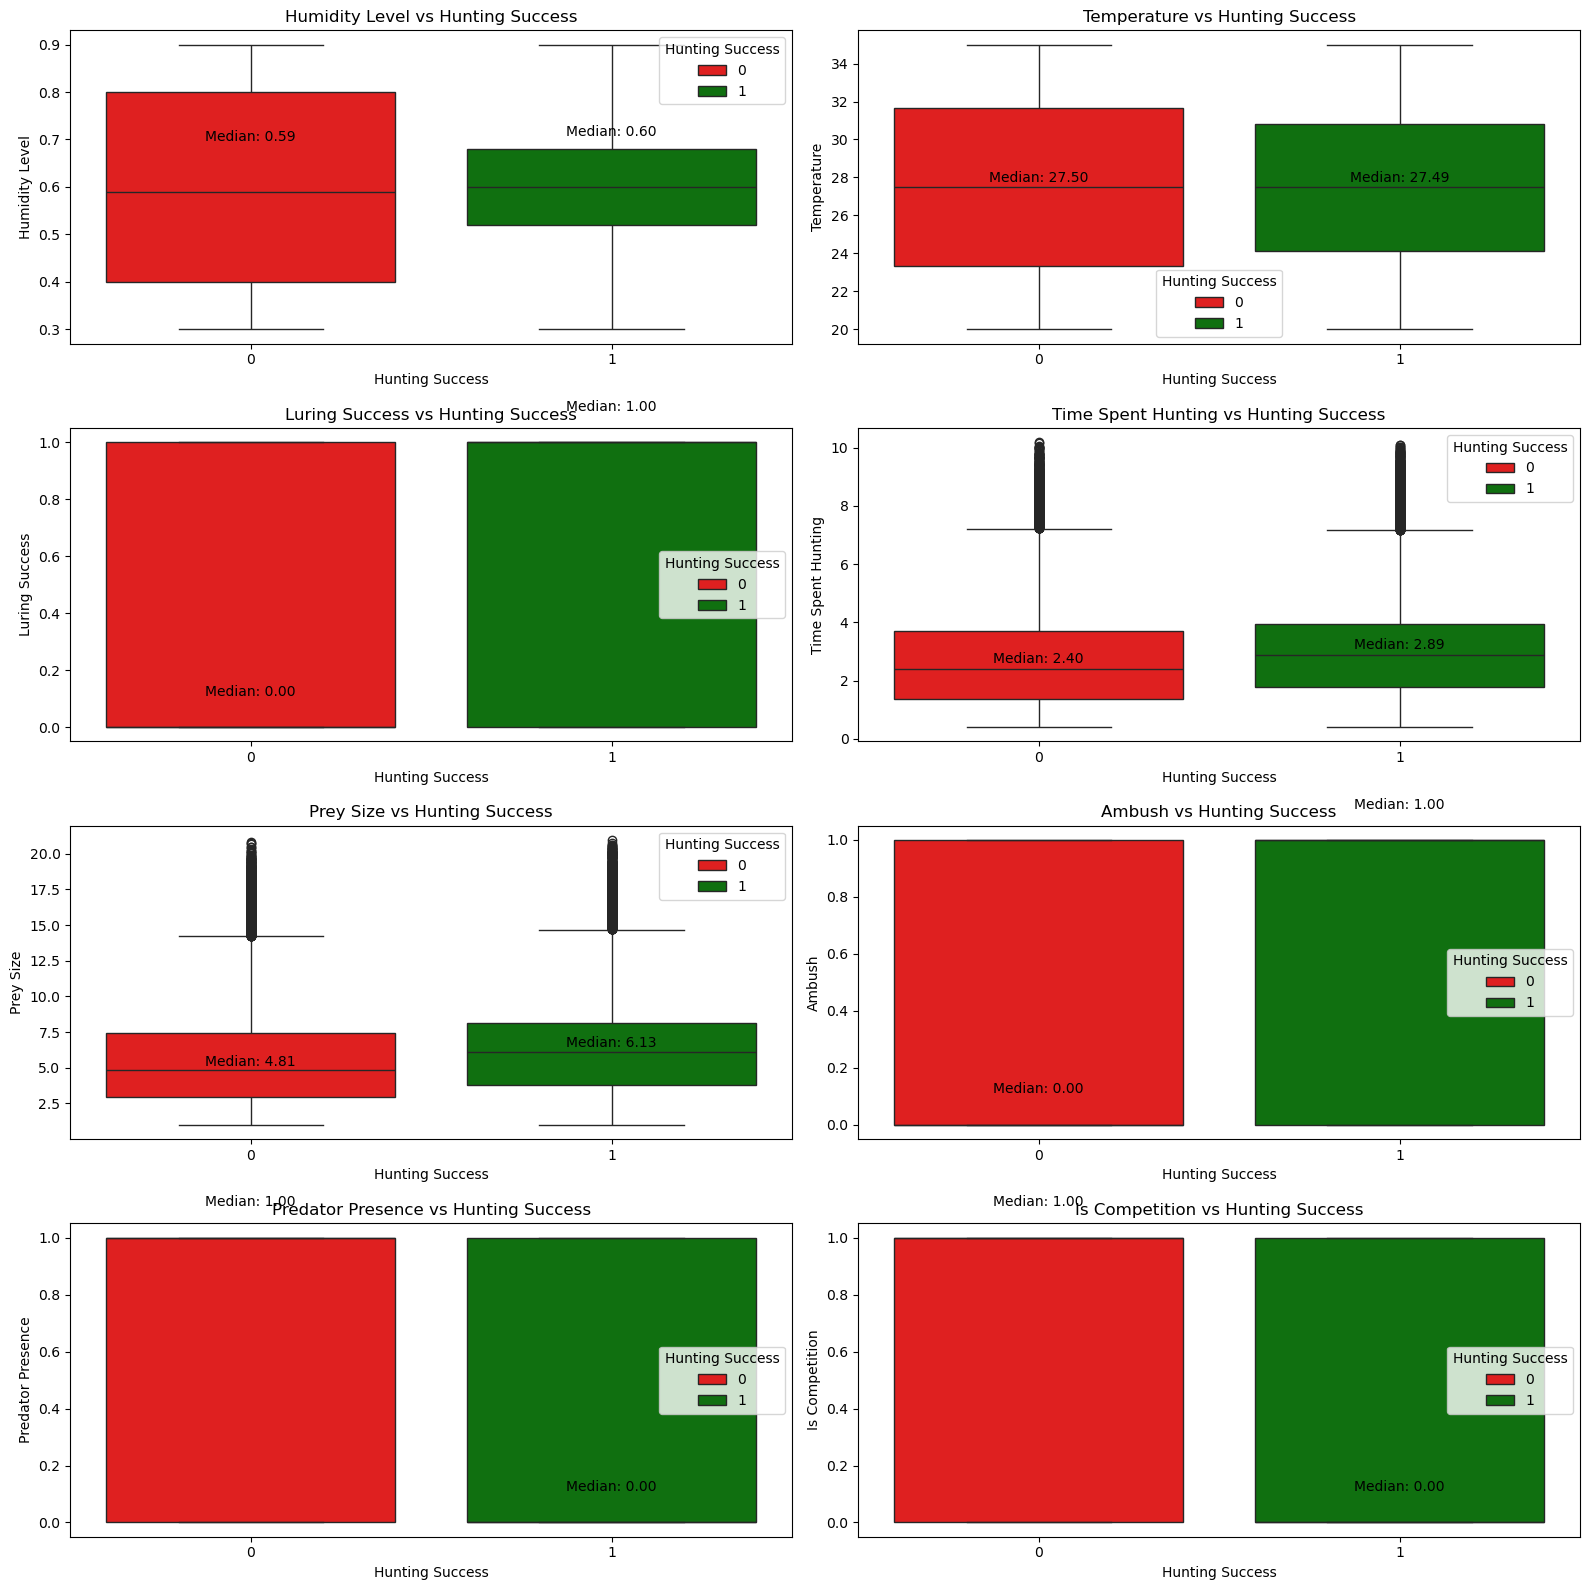

In [ ]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()

num_cols.remove('Hunting Success')
n_cols = 2  
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))

for i, col in enumerate(num_cols):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axes[row, col_idx]
    sns.boxplot(x='Hunting Success', y=col, data=dataset, ax=ax, palette=('red', 'green'), hue='Hunting Success')
    ax.set_title(f'{col} vs Hunting Success')

    medians = dataset.groupby('Hunting Success')[col].median()
    for j, median in enumerate(medians):
        ax.text(j, median + 0.1, f'Median: {median:.2f}', ha='center', va='bottom', fontsize=10, color='black')

for i in range(len(num_cols), n_rows * n_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axes[row, col_idx].axis('off')

plt.tight_layout()
plt.show()

Outliers

U prethodnoj analizi, primećeno je na osnovu boxplot-a da se outlier-i nalaze samo u kolonama Time Spent Hunting i Prey Size,a na osnovu histograma sa KDE vidi se da je distribucija podataka asimetrična, pa je zbog toga za detekciju broja outlier-a korišena IQR metoda. 

In [ ]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')
 
recommendations = []
 
for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
    outliers_data = dataset[outliers_mask]
    outlier_pct = (len(outliers_data) / len(dataset)) * 100
    
    if len(outliers_data) > 0:
        outlier_success_rate = outliers_data['Hunting Success'].mean()
        normal_success_rate = dataset[~outliers_mask]['Hunting Success'].mean()
        impact = abs(outlier_success_rate - normal_success_rate)
    else:
        impact = 0
    recommendations.append({
        'Kolona': col,
        'Broj outlier-a': len(outliers_data),
        'Procenat': f"{outlier_pct:.2f}%",
        'Uticaj na target': f"{impact*100:.2f}%",
    })
 
rec_df = pd.DataFrame(recommendations)
rec_df

,Kolona,Broj outlier-a,Procenat,Uticaj na target
0,Humidity Level,0,0.00%,0.00%
1,Temperature,0,0.00%,0.00%
2,Luring Success,0,0.00%,0.00%
3,Time Spent Hunting,1616,0.55%,3.04%
4,Prey Size,1676,0.57%,7.07%
5,Ambush,0,0.00%,0.00%
6,Predator Presence,0,0.00%,0.00%
7,Is Competition,0,0.00%,0.00%


Korelaciona matrica

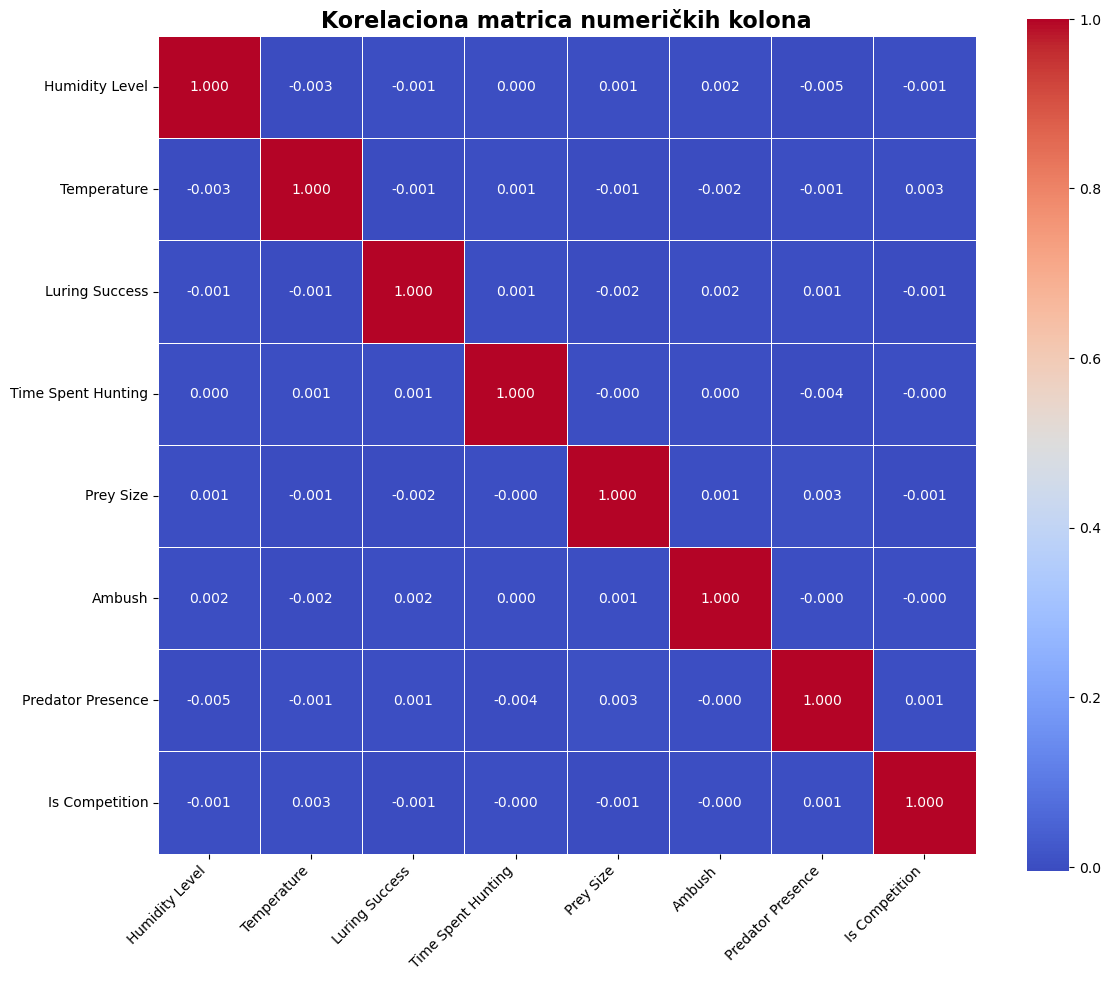

In [ ]:
corr_matrix = dataset[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5, square=True)
plt.title('Korelaciona matrica numeričkih kolona', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Analiza kategorijskih kolona

In [ ]:
cat_cols = dataset.select_dtypes(include=['object']).columns.tolist()
print(f'Kategorijske kolone: {cat_cols}')


Kategorijske kolone: ['Time of Day', 'Food Availability']


Value counts za kategorijske kolone


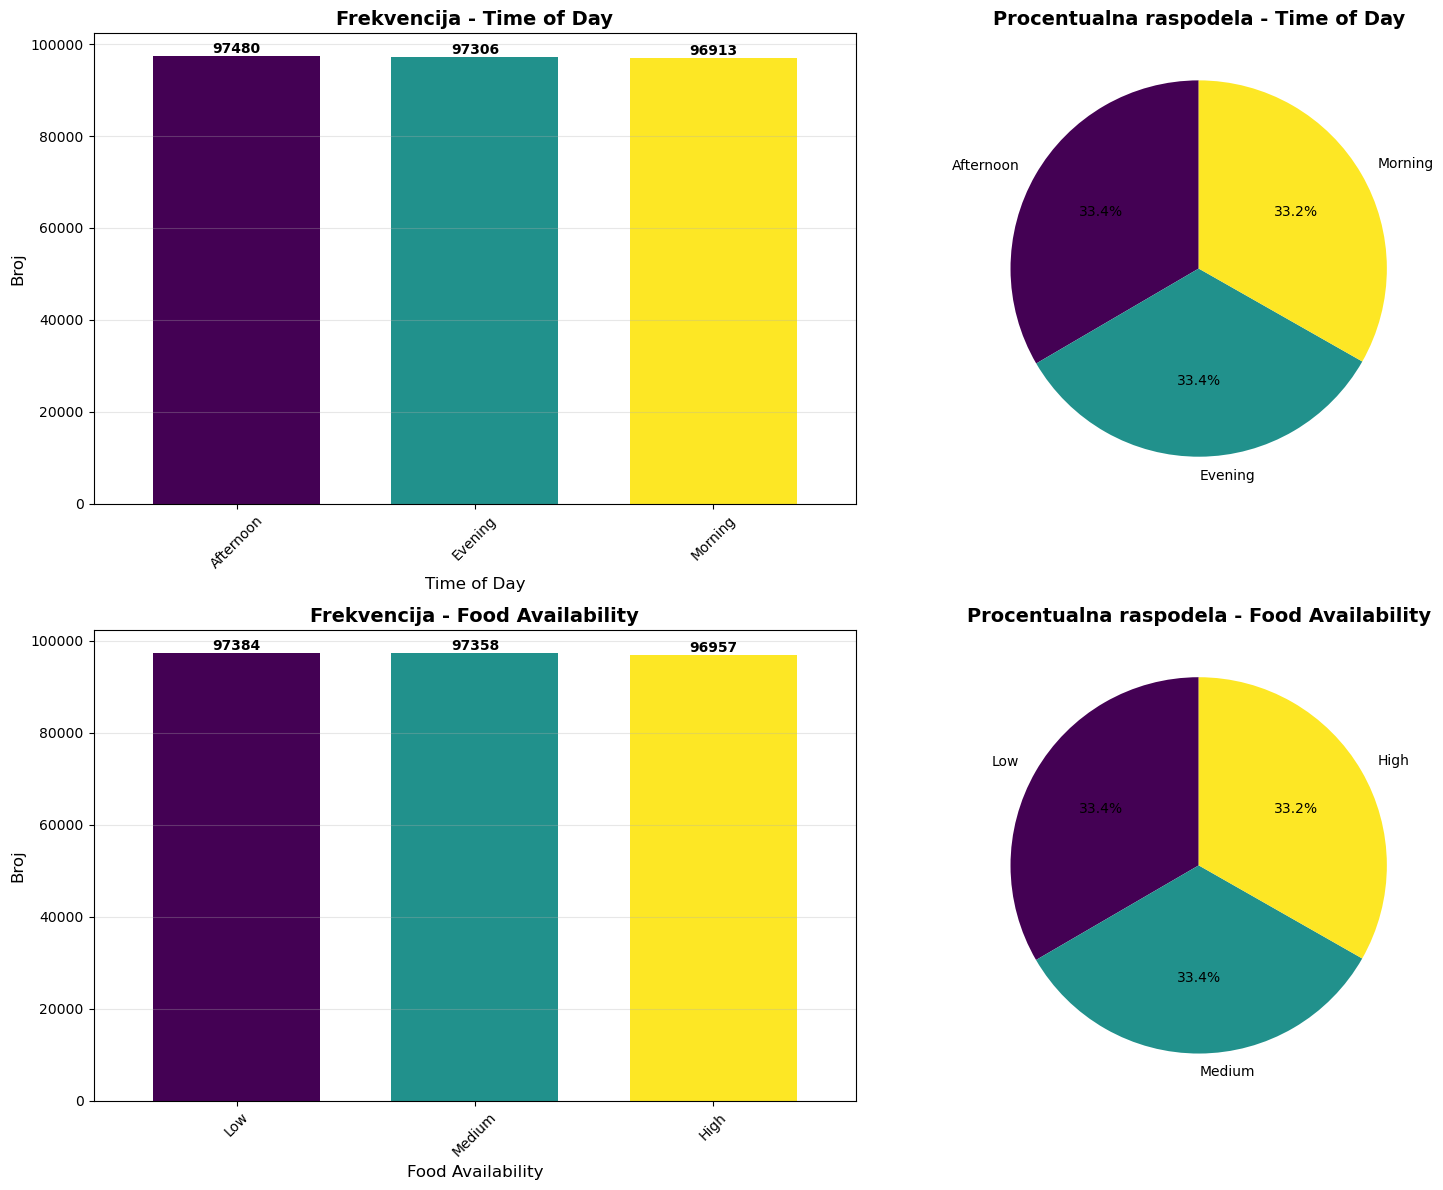

In [ ]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=2, figsize=(16, 6 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    value_counts = dataset[col].value_counts()
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(value_counts)))
    value_counts.plot(kind='bar', ax=axes[i, 0], color=colors, width=0.7)
    axes[i, 0].set_title(f'Frekvencija - {col}', fontsize=14, fontweight='bold')
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel('Broj', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].grid(axis='y', alpha=0.3)
    
    for container in axes[i, 0].containers:
        axes[i, 0].bar_label(container, fmt='%d', fontweight='bold')
    
    axes[i, 1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', 
                   startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(value_counts))))
    axes[i, 1].set_title(f'Procentualna raspodela - {col}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Grupisanje kategorijskih kolona po target (Hunting Success)


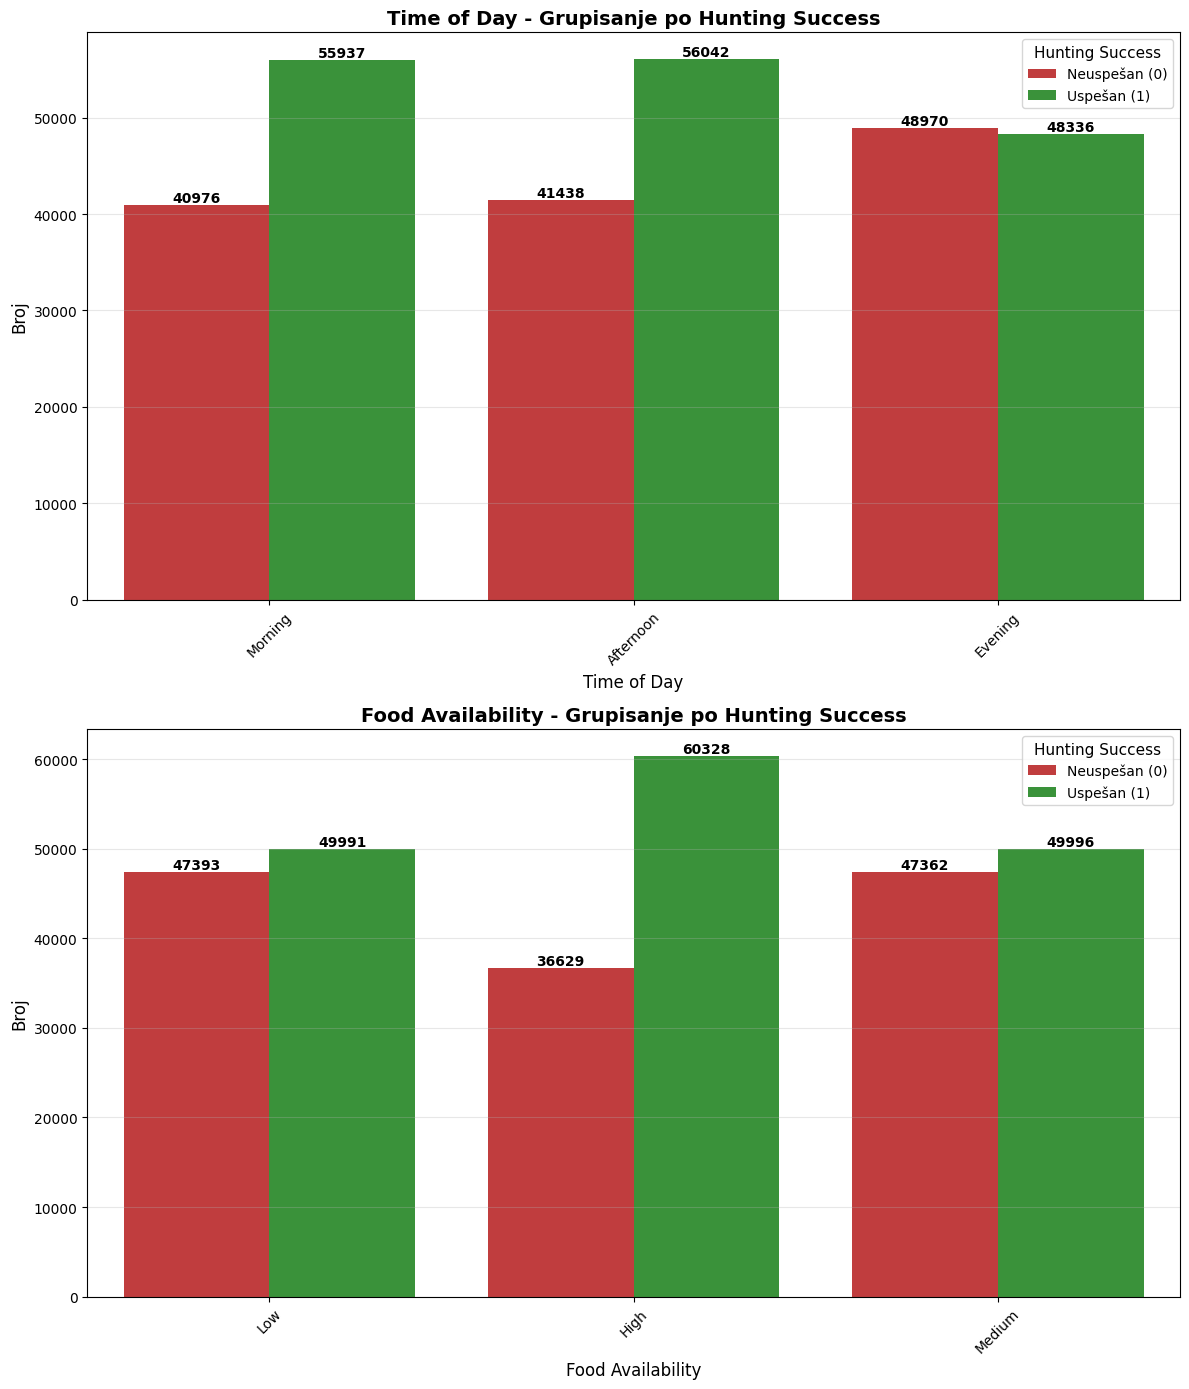

In [ ]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 7 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    sns.countplot(data=dataset, x=col, hue='Hunting Success', ax=axes[i], palette=['#d62728', '#2ca02c'])
    axes[i].set_title(f'{col} - Grupisanje po Hunting Success', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Broj', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Hunting Success', labels=['Neuspešan (0)', 'Uspešan (1)'], title_fontsize=11, fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)
    
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
mode_data = []
 
for col in cat_cols:
    mode_total = dataset[col].mode()
    mode_total_value = mode_total.iloc[0] if len(mode_total) > 0 else None
    mode_total_count = (dataset[col] == mode_total_value).sum() if mode_total_value else 0

    dataset_0 = dataset[dataset['Hunting Success'] == 0]
    mode_0 = dataset_0[col].mode()
    mode_0_value = mode_0.iloc[0] if len(mode_0) > 0 else None
    mode_0_count = (dataset_0[col] == mode_0_value).sum() if mode_0_value else 0

    dataset_1 = dataset[dataset['Hunting Success'] == 1]
    mode_1 = dataset_1[col].mode()
    mode_1_value = mode_1.iloc[0] if len(mode_1) > 0 else None
    mode_1_count = (dataset_1[col] == mode_1_value).sum() if mode_1_value else 0
    mode_data.append({
        'Kategorijska kolona': col,
        'Mode (Ukupno)': mode_total_value,
        'Mode (Hunting Success = 0)': mode_0_value,
        'Mode (Hunting Success = 1)': mode_1_value,
    })
 
mode_df = pd.DataFrame(mode_data)
mode_df

,Kategorijska kolona,Mode (Ukupno),Mode (Hunting Success = 0),Mode (Hunting Success = 1)
0,Time of Day,Afternoon,Evening,Afternoon
1,Food Availability,Low,Low,High
